# Internal Evaluation

TODO:
   - Check of softmax is appropriate for ROC
   - Make graphs more readable

In [72]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import roc_curve, roc_auc_score
import random
import tqdm
import sys

In [2]:
embeddings = pickle.load(open('./embeddings/emb50all', 'rb'))

In [3]:
embeddings_small = embeddings[:10000]
X = np.asarray(embeddings_small.loc[:, 'e1':'e32'])
y = np.asarray(embeddings_small['target'])

In [8]:
def softmax_function(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def label_positive(row, label, y):
    if y[int(row['index'])]==label:
        return True
    return False

def internal_evaluate(query_embedding, query_class, X, y):
    cosines = np.dot(X, query_embedding.reshape(32, 1))
    softmax = softmax_function(cosines).flatten()
    sorted_softmax = list(zip(softmax, range(len(y))))
    sorted_softmax.sort(reverse=True)
    ordered = pd.DataFrame(sorted_softmax, columns=['softmax', 'index'])
    ordered['label'] = ordered.apply(lambda row: label_positive(row, query_class, y), axis=1)
    positives = ordered.index[ordered['label']==True].tolist()
    quantiles = []
    pos = 0
    total_negs = len(y)-len(positives)
    for a in range(len(positives)):
        quantiles.append((positives[a]-pos)/total_negs)
        pos+=1
    return ordered, positives, quantiles
    

In [25]:
ind = 3277
df, positives, quantiles = internal_evaluate(X[ind], y[ind], X, y)

### Recall by Quantile

Median Quantile: 0.18487648122112874


,Quantile,Recall
0,0.001,0.071429
1,0.010,0.166667
2,0.050,0.285714
3,0.100,0.404762
4,0.200,0.500000
5,0.300,0.642857


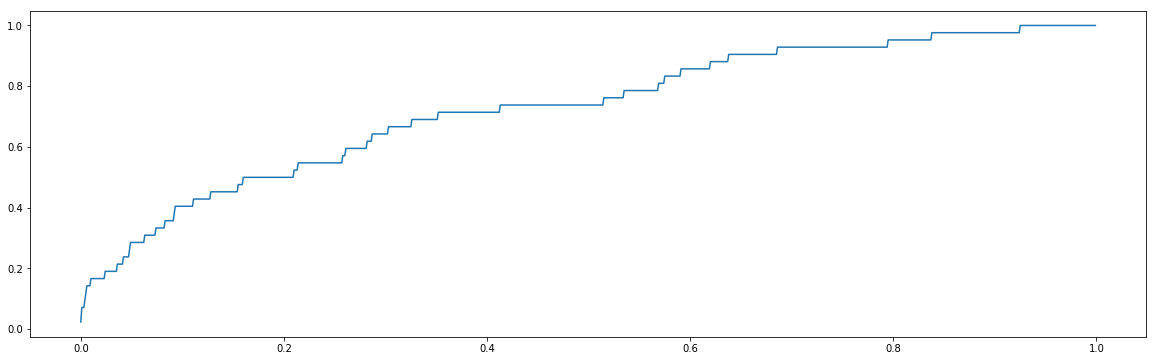

In [26]:
x_quantile = {}
for a in np.arange(0, 1, 0.001):
    x_quantile[round(a, 3)] = 0
# y_recall = []
for a in quantiles:
    x_quantile[round(a, 3)]+=(1/len(quantiles))
for a in np.arange(0.001, 1, 0.001):
    x_quantile[round(a, 3)]+=x_quantile[round(a-0.001, 3)]
x_values = x_quantile.keys()
y_values = x_quantile.values()

imp_q = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
imp_q_val = [x_quantile[round(a, 3)] for a in imp_q]

print("Median Quantile:", np.median(quantiles))

results = pd.DataFrame(list(zip(imp_q, imp_q_val)), columns=['Quantile', 'Recall'])
display(HTML(results.to_html()))

plt.figure(figsize=[20,6])
plt.plot(x_values, y_values)
plt.show()

### ROC Curve

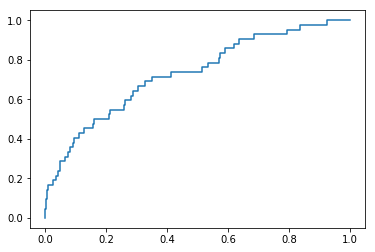

AUC:  0.7290357597146109


In [27]:
fpr, tpr, thresholds = roc_curve(df['label'], df['softmax'])
plt.plot(fpr, tpr)
plt.show()
print("AUC: ", roc_auc_score(df['label'], df['softmax']))

### Combined Function

In [66]:
def full_internal_evaluation(query_embedding, query_class, X, y, printinfo=False):
    cosines = np.dot(X, query_embedding.reshape(32, 1))
    softmax = softmax_function(cosines).flatten()
    sorted_softmax = list(zip(softmax, range(len(y))))
    sorted_softmax.sort(reverse=True)
    ordered = pd.DataFrame(sorted_softmax, columns=['softmax', 'index'])
    ordered['label'] = ordered.apply(lambda row: label_positive(row, query_class, y), axis=1)
    positives = ordered.index[ordered['label']==True].tolist()
    quantiles = []
    pos = 0
    total_negs = len(y)-len(positives)
    for a in range(len(positives)):
        quantiles.append((positives[a]-pos)/total_negs)
        pos+=1
        
    x_quantile = {}
    for a in np.arange(0, 1.001, 0.001):
        x_quantile[round(a, 3)] = 0
    # y_recall = []
    for a in quantiles:
        x_quantile[round(a, 3)]+=(1/len(quantiles))
    for a in np.arange(0.001, 1.001, 0.001):
        x_quantile[round(a, 3)]+=x_quantile[round(a-0.001, 3)]
    x_values = x_quantile.keys()
    y_values = x_quantile.values()

    imp_q = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
    imp_q_val = [x_quantile[round(a, 3)] for a in imp_q]
    
    median = np.median(quantiles)
    if printinfo:
        print("Median Quantile:", median)

    results = pd.DataFrame(list(zip(imp_q, imp_q_val)), columns=['Quantile', 'Recall'])
    if printinfo:
        display(HTML(results.to_html()))
    
        plt.figure(figsize=[20,6])
        plt.plot(x_values, y_values)
        plt.show()
    auc = roc_auc_score(ordered['label'], ordered['softmax'])
    if printinfo:
        fpr, tpr, thresholds = roc_curve(ordered['label'], ordered['softmax'])
        plt.plot(fpr, tpr)
        plt.show()
    
        print("AUC: ", auc)
    
    return median, auc

In [67]:
#5136
ind = 218#random.randint(0, 10000)
print(ind, y[ind])
full_internal_evaluation(X[ind], y[ind], X, y)

218 5


(0.5659771038361117, 0.45823410705917234)

In [74]:
medians = []
aucs = []

for a in range(10000):
    sys.stdout.flush()
    sys.stdout.write("\r%d/10000" % a)
    m, au = full_internal_evaluation(X[a], y[a], X, y)
    medians.append(m)
    aucs.append(au)

9999/10000